<a href="https://colab.research.google.com/github/inandout-kr/timeSeriesAnalysis/blob/main/MachineLearningForTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cesium

     |████████████████████████████████| 220 kB 5.2 MB/s 
     |████████████████████████████████| 554 kB 63.8 MB/s 
  Created wheel for gatspy: filename=gatspy-0.3-py3-none-any.whl size=43818 sha256=3d10bec5d7fe2d4644177022c6fc0fd553f2bccde4096abb26bbba2cb4a941c2
  Stored in directory: /root/.cache/pip/wheels/1f/c1/4c/8de278f816259b4f67e2356c0bda260a593375661e400bf31f
Successfully built gatspy


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

import cesium
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from cesium import datasets
from cesium import featurize as ft

import scipy
from scipy.stats import pearsonr, spearmanr
from scipy.stats import skew

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV 

# **ML for Time Series 시계열을 위한 머신러닝**

Clustering과 tree based method로 predict와 classification 문제를 다룬다.

시계열의 특징 생성은 tree based method에서 반드시 필요한 과정이다. 앞서 공부했던 ARIMA 모델과는 달리 '시간을 인식'하는 방법론이 아니기 때문이다.

Clustering, 거리 기반 classification은 input으로 원본 시계열이나 특징을 사용할 수 있다.

시계열 자체를 input으로 사용하려면, dynamic time warping(DTW, 동적시간워핑)이라는 거리 평가 지표를 알아야 한다.

시계열에 직접적으로 적용되는 동적시간워핑은 데이터 전체에 대한 시간 정보를 보존한다. 제한된 특징 목록을 사용하는 방법과는 다르다.

## **1. 시계열 분류**
- Electroencephalogram(EEG, 원시 뇌전도) 시계열 데이터에 대한 특징을 만드는 예
    - 머신러닝 알고리즘에 사용
- EEG 시계열 특징 추출 후, decision tree(결정 트리) 기법으로 EEG 데이터 분류

### **1.1 특징의 선택과 생성**
- cesium 패키지로 특징 생성
    - 장점 중 한 가지는, 여러 가지 유용한 데이터셋을 제공한다는 점

데이터셋에 다섯 종류의 EEG 시게열이 존재하고, 각 시계열은 모두 길이가 다르다.

In [ ]:
# cesium 함수 사용해 데이터셋 다운로드
from cesium import datasets
eeg = datasets.fetch_andrzejak()

In [ ]:
type(eeg)

dict

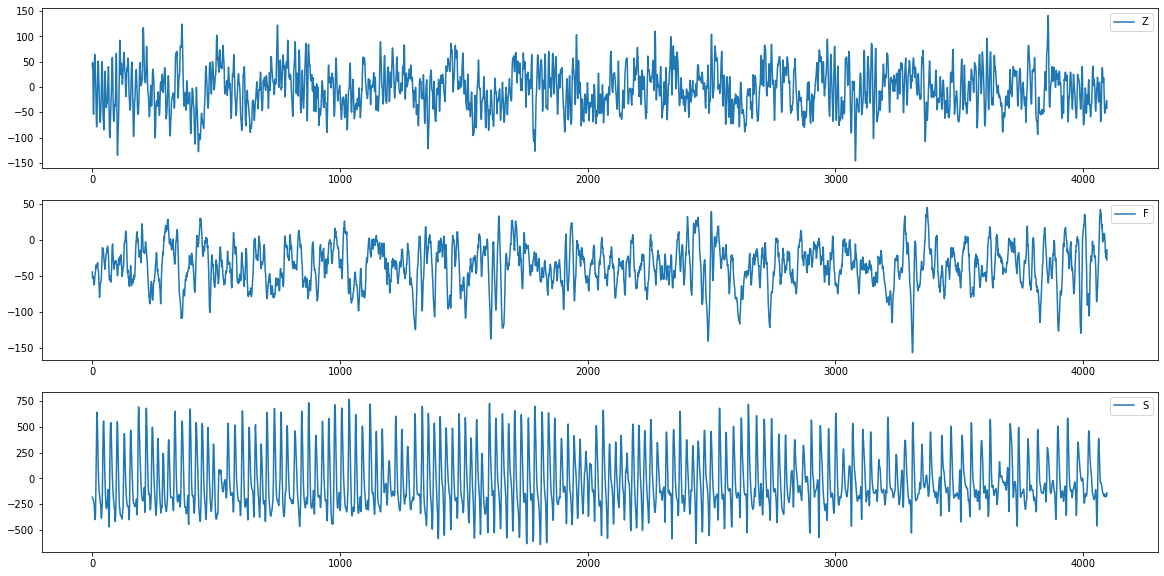

In [ ]:
# 샘플 확인
plt.subplot(3, 1, 1)
plt.plot(eeg["measurements"][0])
plt.legend(eeg['classes'][0])
plt.subplot(3, 1, 2)
plt.plot(eeg["measurements"][300])
plt.legend(eeg['classes'][300])
plt.subplot(3, 1, 3)
plt.plot(eeg["measurements"][450])
plt.legend(eeg['classes'][450])

EEG 데이터셋 중 임의로 선택된 세 개의 표본에 대한 그래프.

건강한 사람과 간질 환자를 대상으로 서로 다른 두뇌 활동을 측정한 것. 서로 독립적이다.

이는 특징 생성에 대한 가이드를 제공한다. 

가령 Z와 F는 S보다 덜 편향된 것으로 보이고, y축을 보면 각 범주는 꽤 다른 범위의 값으로 구성되었다.
- 진폭이 유용할 수 있다는 것을 시사
- 단지 진폭 뿐이 아니라, 서로 다른 특성을 지닌 것으로 보이는 데이터의 전반적인 분포도 유용


In [ ]:
eeg['measurements']

[array([ 40.,  48.,  35., ..., -34., -27., -42.]),
 array([ -56.,  -50.,  -64., ..., -173., -162.,  -82.]),
 array([-37., -22., -17., ...,   3.,   4.,  82.]),
 array([-31., -43., -39., ...,  -6.,  10.,  33.]),
 array([ 14.,  26.,  32., ..., -32.,  -6., -17.]),
 array([-87., -89., -73., ...,  18.,   7.,   7.]),
 array([ -2.,  20.,  42., ..., -18.,  -6., -37.]),
 array([-31., -16.,  10., ...,   1.,   1.,   0.]),
 array([  8.,  17.,  29., ..., -40., -36.,   7.]),
 array([-41., -38., -31., ...,   1., -13.,  -1.]),
 array([ 14.,  25.,  31., ..., -26., -28.,  21.]),
 array([-64., -72., -52., ..., -36., -58.,  20.]),
 array([ 10.,  -6., -14., ...,  15.,   6., -46.]),
 array([31., 25., 17., ..., 23., 28., 65.]),
 array([ 30.,  19.,  -3., ..., -11., -13.,  -6.]),
 array([ 34.,  34.,  31., ...,  -7., -20.,  91.]),
 array([-62., -55., -44., ..., -20., -22.,  35.]),
 array([-18.,  -9.,   9., ..., 109.,  67.,  50.]),
 array([  0.,   2.,  -1., ...,  23.,  21., -16.]),
 array([-20.,  -3.,   2., ..., 

In [ ]:
eeg["measurements"][0]

array([ 40.,  48.,  35., ..., -34., -27., -42.])

In [ ]:
len(eeg["measurements"][0])

4097

In [ ]:
type(eeg["measurements"][0])

numpy.ndarray

In [ ]:
type(eeg)

dict

In [ ]:
eeg.keys()

dict_keys(['times', 'measurements', 'classes', 'archive', 'header'])

In [ ]:
type(eeg['measurements'])

list

In [ ]:
len(eeg['measurements'])

500

In [ ]:
eeg['measurements'][0].shape

(4097,)

#### cesium으로 특징을 생성하는 방법

In [ ]:
from cesium import featurize as ft
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "percent_close_to_median",
                  "skew",
                  "max_slope"]
fset_cesium = ft.featurize_time_series(times=eeg["times"],
                                              values=eeg["measurements"],
                                              errors=None,
                                              features_to_use=features_to_use,
                                             scheduler = None)

In [ ]:
fset_cesium

feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
channel,0,0,0,0,0
0,143.5,0.327313,0.505004,0.032805,11107.796610
1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,171.5,0.300952,0.541128,0.063678,17008.813559
4,170.0,0.305101,0.566268,0.142753,13016.949153
...,...,...,...,...,...
495,876.5,0.368318,0.364413,-0.472757,94242.711864
496,433.0,0.361728,0.394923,0.046880,27595.932203
497,1359.0,0.270442,0.628265,-0.468130,243156.610169


*정규화되지 않은 값이 많다는 사실 유의(일부 기법은 정규화된 input을 가정)
- 잘 생성되었나 검증해보자
  - 오류 검사와 상식적인 확인의 한 예로, 시계열 샘플의 percent_beyond_1_std 확인 가능

In [ ]:
std = np.std(eeg['measurements'][0])
std

40.41100040099819

In [ ]:
mean = np.mean(eeg['measurements'][0])
mean

-4.1320478398828415

In [ ]:
sample_ts = eeg['measurements'][0]
sz = len(sample_ts)
ll = mean - std
ul = mean + std
quals = [i for i in range(sz) if sample_ts[i] < ll or
         sample_ts[i] > ul]

len(quals) / sz

0.3273126678057115

In [ ]:
fset_cesium.iloc[0, 1]

0.3273126678057115

특징 생성 라이브러리를 과하기 사용하지 말자.

자신만의 특징 생성용 코드를 작성해두자.

패키지가 제공할 수 없는 코드의 최적화가 가능하기 때문.

가령 시계열의 평균에 의존적인 여러 특징이 있다면, 평균을 매번 계산하기보다 한 번만 계산하는 코드를 작성할 수 있음.

### **1.2 결정 트리 기법**
- **결정 트리(Decision Tree, 의사결정나무라고도 함)는, 나무 형태의 판단 규칙 조합을 만들어서 기존 데이터를 학습하고 그 다음에 예측하는 알고리즘을 말한다. 쉽게 생각하면 어렸을 적의 ‘스무고개’ 놀이와 같은 개념이다**(삼성증권 김동영, 2019). 


한 번에 한 단계씩, 비선형적인 방식으로 결정

한 번에 한 단계씩, 한 변수가 결정에 미치는 영향력을 생각하는 과정 반복

- 결정 트리에 대해 잘 모른다면 참고:
  - https://perma.cc/G9AA-ANEN (https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052)


#### **1.2.1 랜덤포레스트**

- **앞서 언급한 ‘결정 트리’ 모델에 배깅(bagging, bootstrap aggregating) 기법을 적용한 앙상블 모델을, 특별히‘랜덤 포레스트’ 모델이라고 한다. 하나의 데이터 소스에서 랜덤하게 데이터들을 만들어 여러 개의 학습된 결정 트리 모델을 만들고 이를 종합하는 방식이다**(삼성증권 김동영, 2019). 

- 하나가 아닌, 여러 개의 결정 트리 사용
- 분류 혹은 회귀의 결과는 각 트리가 내놓은 출력의 평균을 사용
- 여러 간단한 결정 트리 모델을 합쳐 '군중의 지혜' 효과 기대(단 하나의 최고의 모델을 찾는 대산, 여러 모델 무리를 앙상블하여 예측)
- 랜덤포레스트는 학습될 트리의 개수, 각 트리에 허용되는 최대 깊이에 대한 파라미터에 따라 구조가 결정됨
  - 각 개별 트리는 임의로 선정된 데이터 표본과 특징으로 학습됨
  - 각 트리는 과적합을 피할 수 있도록 꽤 간단한 파라미터로 구성하는 것이 일반적
  - 일반화된 여러 모델이 협력해 평균 도출
  - 충분히 일반화된 결과 도출 가능


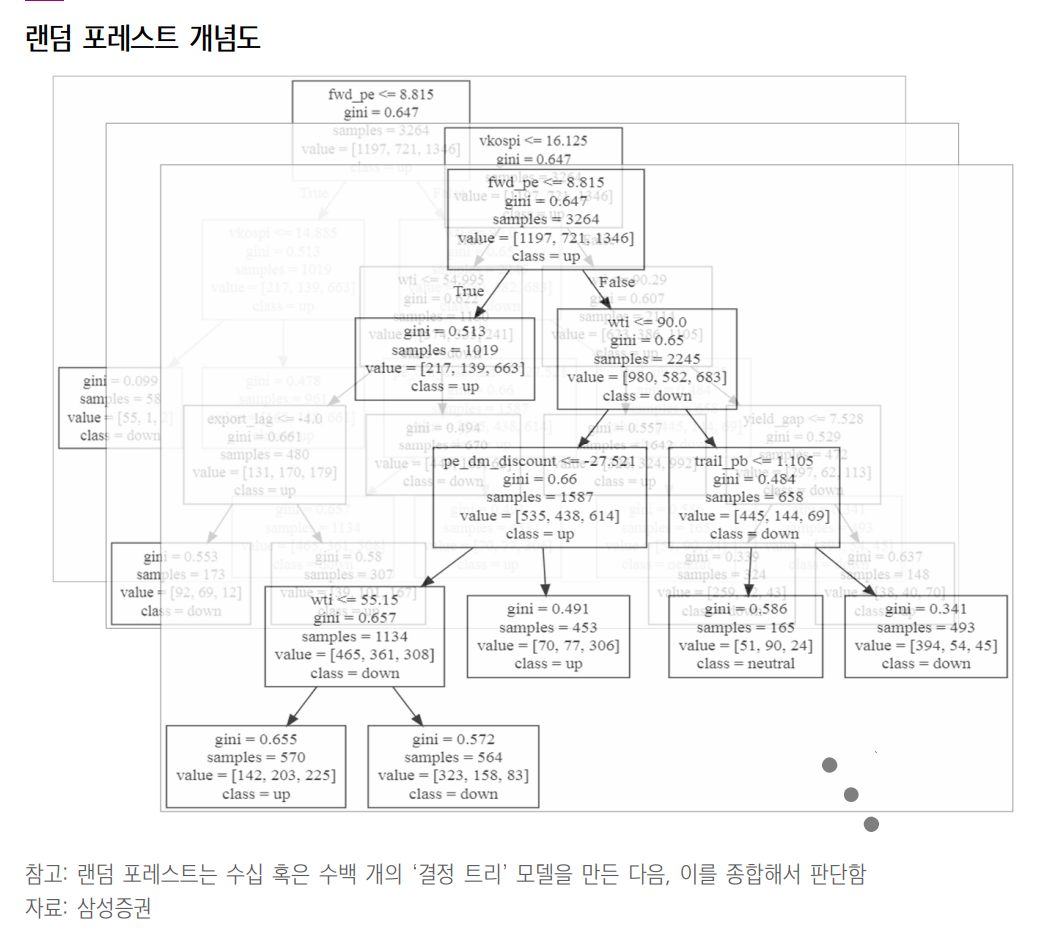

각 시계열 샘플의 계산된 특징을 모델에 입력.

원시 시계열 데이터는 다음의 잠재적인 문제를 가지고 있음
- 균일하지 않은 길이의 시계열을 다루는 건 복잡함
- (시간 단계의 개수와 동등한 수준의) 대규모 입력은 계산 비용이 비싼 모델과 학습 과정의 결과를 초래
- (모든 시간 단계는 한 특징으로 매핑되기 때문에) 특정 시간 단계가 매우 중요하지 않다고 가정하면, 트리 관점에서는 시간 단계를 개별 입력으로 봐서 **매우 심한 노이즈**와 **약한 신호**만 존재

따라서 원시 시계열 데이터로 작업할 때, 랜덤포레스트가 좋은 도구는 아님. 그러나 원시 데이터가 특징들로 압축되어 요약되면 매우 유용할 수 있다.





- 유용성을 뒷받침하는 구체적인 이유
  - 효율성/계산 자원 관점에서, 매우 긴 시계열을 소수의 특징으로 추출하고 의미 있는 정확도를 가진 모델을 찾을 수 있다는 건 훌륭하다.
  - 랜덤포레스트는 과적합의 위험을 줄이는 데 좋다. 고의적으로 단순한 방법을 사용하면 이런 우려의 일부를 해결할 수 있다.
  - 랜덤포레스트는 process의 기본 동작에 대해 작동하는 모델이나, 가설이 없는 시계열 데이터에 특히 적합할 수 있다.

**일반적으로 랜덤포레스트는 시계열 예측보다 시계열 분류에서 더 많은 성공을 거두었다.**

#### **1.2.2 그레이디언트 부스팅 트리**
- Boosting은 모델들의 앙상블을 구축하는 또 다른 방법
- 차례대로 생성되는 모델 중, 나중에 생성되는 모델이 이전 모델의 실수를 바로잡는 방향을 가짐
  - 즉 이전 모델에서 잘못 적합된 데이터는 나중 모델에서 더 큰 가중치를 가지게 되는 방식

- 그레이디언트 부스팅에 대해 잘 모른다면 참고:
  - https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-15-Gradient-Boost


**XGBoost**는 트리를 차례대로 만든다. 이때 각 트리는 이전 트리들의 결합에 대한 잔차를 예측한다.

가령 XGBoost로 구축된 첫 번째 트리는 데이터와 일치하려고 시도하고, 두 번째 트리는 참값(target)에서 예측된 값을 뺀 **잔차**를 예측한다. 세 번째 트리는 참값에서 첫 번째 트리가 예측한 값, 첫 번째 트리의 잔차에 대해 두 번째 트리가 예측한 값을 뺀 것을 예측한다.


------------------
#### **예제 code**
앞서 생성한 특징을 기반으로 랜덤포레스트와 그레이디언트 부스팅 트리 모델을 모두 학습시켜서 EEG 데이터를 분류한다.

In [ ]:
# 학습용, 테스트용 데이터셋 분리
from sklearn.model_selection import train_test_split  # 혼공머신 Ch.2에서도 나왔던 것
X_train, X_test, y_train, y_test = train_test_split(fset_cesium.values, eeg['classes'], random_state=21)

In [ ]:
fset_cesium.values

array([[ 1.43500000e+02,  3.27312668e-01,  5.05003661e-01,
         3.28049964e-02,  1.11077966e+04],
       [ 2.11500000e+02,  2.90212351e-01,  6.40468636e-01,
        -9.27149921e-02,  2.06535593e+04],
       [ 1.65000000e+02,  3.02660483e-01,  5.15987308e-01,
        -4.09990842e-03,  1.35376271e+04],
       ...,
       [ 1.35900000e+03,  2.70441787e-01,  6.28264584e-01,
        -4.68130248e-01,  2.43156610e+05],
       [ 1.59000000e+03,  3.05589456e-01,  4.89138394e-01,
        -6.74033914e-01,  1.76856949e+05],
       [ 1.39600000e+03,  2.25774957e-01,  6.06785453e-01,
        -1.34775823e+00,  1.31037288e+05]])

In [ ]:
eeg['classes']

array(['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

In [ ]:
X_train

array([[ 1.06750000e+03,  2.97778863e-01,  5.87503051e-01,
        -6.26535406e-03,  1.01705763e+05],
       [ 1.83500000e+02,  2.49938980e-01,  6.09714425e-01,
        -9.37163974e-01,  1.18020339e+04],
       [ 2.25000000e+02,  3.15596778e-01,  5.30388089e-01,
        -1.15128193e-01,  1.38847458e+04],
       ...,
       [ 8.95000000e+01,  3.15108616e-01,  5.25018306e-01,
        -2.69978337e-01,  5.55389831e+03],
       [ 9.40000000e+01,  3.08762509e-01,  5.15255065e-01,
        -1.85895885e-01,  3.29762712e+03],
       [ 3.75500000e+02,  3.19257994e-01,  4.91335123e-01,
        -1.47063561e-01,  2.18684746e+04]])

In [ ]:
y_train

array(['S', 'N', 'O', 'F', 'F', 'Z', 'N', 'Z', 'O', 'O', 'O', 'O', 'N',
       'F', 'N', 'O', 'S', 'F', 'Z', 'S', 'O', 'S', 'F', 'O', 'N', 'Z',
       'O', 'S', 'N', 'Z', 'O', 'N', 'F', 'F', 'S', 'Z', 'F', 'O', 'Z',
       'O', 'S', 'Z', 'O', 'Z', 'N', 'S', 'Z', 'O', 'N', 'F', 'O', 'Z',
       'O', 'S', 'O', 'O', 'O', 'O', 'S', 'F', 'O', 'S', 'F', 'F', 'S',
       'Z', 'N', 'Z', 'F', 'S', 'F', 'S', 'S', 'S', 'Z', 'Z', 'O', 'F',
       'S', 'Z', 'O', 'Z', 'O', 'Z', 'N', 'F', 'Z', 'Z', 'Z', 'F', 'F',
       'Z', 'F', 'F', 'O', 'O', 'O', 'O', 'N', 'O', 'S', 'F', 'Z', 'N',
       'F', 'O', 'O', 'F', 'N', 'O', 'F', 'N', 'F', 'F', 'S', 'S', 'S',
       'N', 'F', 'S', 'O', 'S', 'O', 'F', 'F', 'F', 'F', 'O', 'S', 'S',
       'S', 'S', 'F', 'Z', 'N', 'O', 'O', 'Z', 'Z', 'Z', 'Z', 'O', 'N',
       'Z', 'Z', 'Z', 'N', 'N', 'F', 'Z', 'O', 'O', 'Z', 'S', 'O', 'N',
       'O', 'Z', 'Z', 'F', 'Z', 'N', 'Z', 'F', 'Z', 'Z', 'N', 'N', 'S',
       'F', 'S', 'O', 'F', 'F', 'O', 'O', 'S', 'N', 'F', 'O', 'F

In [ ]:
# 랜덤포레스트를 사용해 EEG 데이터를 분류하는 모델 생성
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10,
                                max_depth = 3,
                                random_state = 21)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=21)

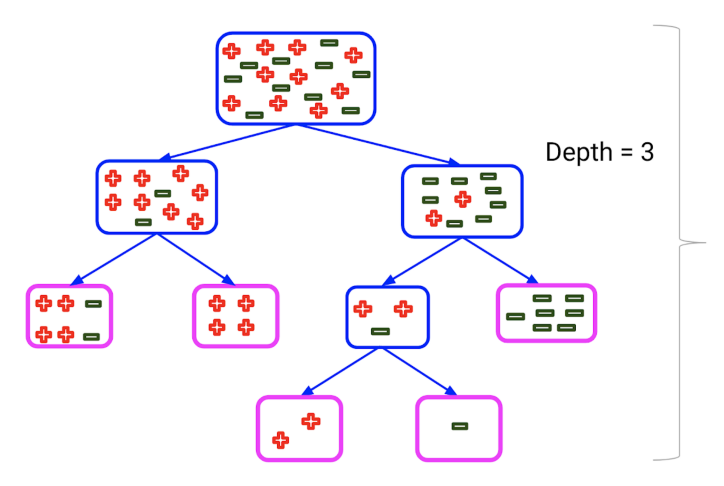

- max_depth: 루트 노드와 리프 노드 사이의 가장 긴 경로
- n_estimators: 나무 개수 (위 삼성증권 자료에서의 페이지 수라고 생각하면 됨)

출처: https://ichi.pro/ko/laendeom-poleseuteu-haipeo-palamiteo-tyuning-e-daehan-choboja-gaideu-77596161963319

In [ ]:
# score method로 학습에 사용되지 않은 테스트 데이터셋에 대한 정확도 결정
rf_clf.score(X_test, y_test)

0.616

약간의 코드 작성으로 (의학에 대해 모르는) 사람이 직접 분류하는 것보다 더 나은 모델을 만들었다. 이 모델은 전체 EEG 데이터 대신, 요약 통계를 입력으로 사용한 것으로, 좋은 특징이 선택된 덕분이라는 것을 기억하자.

In [ ]:
# XGBoost
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators = 10,
                            max_depth = 3,
                            random_state = 21)
xgb_clf.fit(X_train, y_train)
xgb_clf.score(X_test, y_test)

0.648

In [ ]:
# 모델 학습에 소요된 시간 계산
start = time.time()
xgb_clf.fit(X_train, y_train)
end = time.time()
print(f'XGBoost 학습 소요 시간: {end - start}')

start = time.time()
rf_clf.fit(X_train, y_train)
end = time.time()
print(f'Random Forest 학습 소요 시간: {end - start}')

XGBoost 학습 소요 시간: 0.024992942810058594
Random Forest 학습 소요 시간: 0.01795220375061035


(일반적으로 XHBoost가 더 짧게 걸린다고 하는데.. 여긴 반대로 나와 있음. 그러나 상기 코드는 성능 테스트를 수행하는 방법이 아니라는 점을 인지하자.)

-------------------------------
두 앙상블에 대해 통일한 트리 개수를 부여하고, 트리들의 깊이를 제한해서 복잡도를 낮춘 경우.

In [ ]:
xgb_clf = xgb.XGBClassifier(n_estimators = 10,
                            max_depth = 1,
                            random_state = 21)
xgb_clf.fit(X_train, y_train)
print(xgb_clf.score(X_test, y_test))


from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10,
                                max_depth = 1,
                                random_state = 21)
rf_clf.fit(X_train, y_train)
print(rf_clf.score(X_test, y_test))

0.632
0.376


In [ ]:
xgb_clf = xgb.XGBClassifier(n_estimators = 100,
                            max_depth = 10,
                            random_state = 21)
xgb_clf.fit(X_train, y_train)
print(xgb_clf.score(X_test, y_test))


from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 100,
                                max_depth = 10,
                                random_state = 21)
rf_clf.fit(X_train, y_train)
print(rf_clf.score(X_test, y_test))

0.6
0.64


**모델 세부 튜닝: 최적 하이퍼파라미터 찾기**

랜덤 포레스트를 비롯한 많은 머신러닝 모델들은 여러 가지 하이퍼파라미터(모델 외적인 조정 변수)를 가진다. 하이퍼파라미터의 설정에 따라서, 모델의 성능이 차이가 크게 날 수 있다. 따라서, 머신러닝 기법에서는 trial and error 방식으로 하이퍼파라미터를 조금씩 바꿔가면서 모델을 여러 번 테스트해, 최적의 파라미터 세팅을 찾는 기법을 많이 쓴다. 이 때 RandomizedSearchCV가 사용된다. RandomizedSearchCV는 최적 파라미터를 찾을 때 랜덤하게 적절한 수의 조합으로
테스트를 해주는 객체다. 

(출처: 김동영. “코스피 단기예측 AI 모델: 랜덤 포레스트 기법을 활용한 머신러닝 기반 모델.” 삼성증권 Quantitative Issue:, 2019, 20.)


In [ ]:
param_dist_rf = {
'n_estimators': list(range(10, 310, 50)),
'max_depth': list(range(1, 20, 1))
}

rf_search = RandomizedSearchCV(rf_clf, param_dist_rf, cv=10, random_state=21)
rf_search.fit(X_train, y_train)
print(rf_search.best_params_) 


{'n_estimators': 110, 'max_depth': 11}


In [ ]:
rf_clf = RandomForestClassifier(n_estimators = 110,
                                max_depth = 11,
                                random_state = 21)
rf_clf.fit(X_train, y_train)
print(rf_clf.score(X_test, y_test))

0.632


In [ ]:
param_dist_rf = {
'n_estimators': list(range(10, 310, 50)),
'max_depth': list(range(1, 20, 1))
}

xgb_search = RandomizedSearchCV(xgb_clf, param_dist_rf, cv=10, random_state=21)
xgb_search.fit(X_train, y_train)
print(xgb_search.best_params_) 


{'n_estimators': 60, 'max_depth': 2}


In [ ]:
xgb_clf = xgb.XGBClassifier(n_estimators = 60,
                            max_depth = 2,
                            random_state = 21)
xgb_clf.fit(X_train, y_train)
print(xgb_clf.score(X_test, y_test))

0.712


- 이유
  - 분류 작업에 선택된 모든 특징들이 유용하지는 않을 수 있음
  - 부스팅은 항상 모든 특징을 사용하고, 관련도가 높은 것에 특혜를 줘서 의미 없는 특징이 무시될 가능성이 높음
  - 배깅(랜덤포레스트)은 덜 의미 있는 특징을 사용하도록 강요 받을 수 있음
  - 때문에 현실적으로 점검 불가능한 수준으로, 수백 개에 달하는 시계열의 특징을 생성할 때, 부스팅은 최악의 결과에 대한 일종의 안전 장치가 될 수 있다.


-----------------------
여러 통계학자는 예측에 있어서 머신러닝이 전통적인 통계 분석보다 덜 성공했다고 주장한다. 그러나 그레이디언트 부스팅 트리가 등장한 이래로, 큰 데이터가 주어질 때 머신러닝이 전통적인 통계 모델의 성능을 앞지른 경우를 많이 볼 수 있다.

그레이디언트 부스팅 트리 모델의 한 가지 장점은 **'자율적으로'** 접근하는 능력을 가졌다는 것이다.

즉 모델이 스스로 관련성이 적거나 노이즈가 많은 특징은 제거하고, 가장 중요한 특징들에 초점을 맞춘다는 것이다.

그러나 아무리 좋아봐야 input 데이터를 뛰어넘을 수는 없다.

모델을 향상시키기 위한 가장 중요한 벙법은 **검증된 고품질 input 특징**을 제공하는 것이다.




- **모델을 향상하는 여러 방법**
  - XGBoost 옵션으로 생성 가능한 특징 중 **요도** 이용
    - 특징의 유용성 파악에 도움
    - 유용하다고 판단된 특징과 유사한 특징을 추가하는 방식으로 데이터셋 확장 가능
  - 하이퍼파라미터 격자 탐색으로 모델 파라미터 조정
  - 원시 시계열의 잘못 레이블링된 데이터 찾아보고, 현재 모델에 사용된 특징으로 표현 가능한지 확인
    - 잘못 레이블링된 데이터를 보다 잘 묘사하는 특징을 추가해, input을 보강
  


-------------------------------------------------

---



In [ ]:
! pip install dtaidistance

     |████████████████████████████████| 797 kB 5.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for dtaidistance: filename=dtaidistance-2.3.6-cp37-cp37m-linux_x86_64.whl size=1592312 sha256=cff14d7ae94aa9057f182ca29eda155968f671af25119665fc88c5aef9a4a8fb
  Stored in directory: /root/.cache/pip/wheels/a4/04/e5/ff7fd821276e7ec68893652d36b6a13f230ecdcafdc3283b3f
Successfully built dtaidistance


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from math import sqrt

from datetime import datetime
import pandas as pd
import numpy as np
import pdb


from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

from sklearn.metrics.pairwise import pairwise_distances
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import homogeneity_score, completeness_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import homogeneity_score

from dtaidistance import dtw

from collections import Counter

from scipy.stats import pearsonr

## **2. 클러스터링**
기본 개념: 분석의 목적상 서로 유사한 데이터가 의미 있는 집단을 구성한다는 것

(시계열 데이터뿐이 아니라 다른 데이터에도 적용됨)

클러스터링 기법에 대해 잘 모른다면,
* 참고: https://perma.cc/36EX-3QJU (https://www.analyticsvidhya.com/blog/2016/11/an-introduction-to-clustering-and-different-methods-of-clustering/)


In [ ]:
words = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/50words_TEST.csv',
                   header = None)

In [ ]:
words

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270
0,4,-0.89094,-0.86099,-0.82438,-0.78214,-0.73573,-0.68691,-0.637540,-0.589370,-0.543420,-0.500440,-0.460820,-0.424690,-0.39240,-0.36389,-0.339060,-0.317950,-0.300560,-0.286920,-0.277270,-0.271050,-0.267770,-0.266780,-0.267420,-0.269270,-0.272020,-0.275290,-0.278980,-0.283200,-0.288140,-0.294310,-0.301850,-0.310860,-0.321350,-0.333260,-0.346500,-0.361030,-0.376590,-0.39297,-0.409950,...,0.052471,-0.01492,-0.082568,-0.14848,-0.21193,-0.27229,-0.32905,-0.38303,-0.432220,-0.476280,-0.515870,-0.55188,-0.58534,-0.61763,-0.64653,-0.67227,-0.69521,-0.71576,-0.735170,-0.752860,-0.76798,-0.78120,-0.79326,-0.80474,-0.81719,-0.82831,-0.837680,-0.845380,-0.85165,-0.85731,-0.86309,-0.86791,-0.87271,-0.87846,-0.88592,-0.89619,-0.90783,-0.91942,-0.93018,-0.93939
1,12,-0.78346,-0.68562,-0.58409,-0.47946,-0.37398,-0.27008,-0.172250,-0.087463,-0.019191,0.035301,0.080601,0.121210,0.16167,0.20223,0.239730,0.273860,0.305240,0.334170,0.364750,0.399670,0.436950,0.474700,0.509190,0.534400,0.547550,0.549650,0.542360,0.529090,0.515230,0.503070,0.491830,0.482130,0.472450,0.459290,0.443090,0.424040,0.400530,0.37585,0.351890,...,0.711070,0.64773,0.579890,0.50674,0.42767,0.34155,0.24849,0.15221,0.056228,-0.036684,-0.123520,-0.20472,-0.28299,-0.35917,-0.43397,-0.50794,-0.57864,-0.64302,-0.700170,-0.749010,-0.78785,-0.81818,-0.84200,-0.85809,-0.86830,-0.87519,-0.877210,-0.876610,-0.87728,-0.87899,-0.88318,-0.89189,-0.90290,-0.91427,-0.92668,-0.93966,-0.95244,-0.96623,-0.98050,-0.99178
2,13,-1.32560,-1.28430,-1.21970,-1.15670,-1.09980,-1.04960,-1.015500,-0.996720,-0.985040,-0.971990,-0.964030,-0.963550,-0.96236,-0.95077,-0.917330,-0.871050,-0.817930,-0.760640,-0.701060,-0.644150,-0.594710,-0.529310,-0.409210,-0.205990,0.066333,0.344810,0.565100,0.703590,0.785270,0.840450,0.870940,0.857640,0.775790,0.634510,0.480380,0.351620,0.241000,0.11593,-0.022140,...,-0.443510,-0.43741,-0.444480,-0.45708,-0.46691,-0.47419,-0.47495,-0.46916,-0.456730,-0.439730,-0.421350,-0.40614,-0.40352,-0.41293,-0.42965,-0.44611,-0.45623,-0.46585,-0.484310,-0.520100,-0.56853,-0.61788,-0.65943,-0.68651,-0.70204,-0.71318,-0.726460,-0.745680,-0.77144,-0.80390,-0.83499,-0.86204,-0.88559,-0.90454,-0.93353,-0.99135,-1.06910,-1.13680,-1.19800,-1.27000
3,23,-1.09370,-1.04200,-0.99840,-0.95997,-0.93997,-0.93764,-0.926490,-0.857090,-0.693320,-0.312890,0.339420,0.989090,1.33000,1.34950,1.222900,1.044500,0.829670,0.602100,0.365250,0.128330,-0.046387,-0.165640,-0.265030,-0.362500,-0.449520,-0.510830,-0.562550,-0.608530,-0.635880,-0.632320,-0.597000,-0.520320,-0.427310,-0.291990,-0.066752,0.241280,0.610500,0.96181,1.211600,...,1.115600,1.76630,2.558000,3.33430,3.84940,3.90180,3.62190,3.18950,2.623000,2.031000,1.497900,1.00600,0.55445,0.16993,-0.12355,-0.31586,-0.43344,-0.50570,-0.532680,-0.536880,-0.54374,-0.56792,-0.60857,-0.63638,-0.64471,-0.64440,-0.653820,-0.669570,-0.69135,-0.71082,-0.72810,-0.74512,-0.76376,-0.78068,-0.80593,-0.84350,-0.89531,-0.96052,-1.05090,-1.12830
4,4,-0.90138,-0.85228,-0.80196,-0.74932,-0.69298,-0.63316,-0.570380,-0.506920,-0.446040,-0.390180,-0.339310,-0.292310,-0.24833,-0.20635,-0.165850,-0.127190,-0.091931,-0.059946,-0.030921,-0.004628,0.018364,0.038239,0.054732,0.067206,0.075442,0.080507,0.083344,0.083628,0.081179,0.075684,0.066456,0.051670,0.032078,0.008739,-0.017323,-0.046021,-0.075800,-0.10581,-0.136220,...,-0.394410,-0.37672,-0.357160,-0.33905,-0.32255,-0.30807,-0.29818,-0.29607,-0.300260,-0.310800,-0.328090,-0.35262,-0.38035,-0.41034,-0.44236,-0.47573,-0.50864,-0.54145,-0.575060,-0.608890,-0.64237,-0.67593,-0.71042,-0.74502,-0.77959,-0.81402,-0.848050,-0.879590,-0.90785,-0.93276,-0.95452,-0.97322,-0.98984,-1.00520,-1.01880,-1.02960,-1.03700,-1.04110,-1.04180,-1.04030
...,...,...,...,...,...,...,

In [ ]:
words

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270
0,4,-0.89094,-0.86099,-0.82438,-0.78214,-0.73573,-0.68691,-0.637540,-0.589370,-0.543420,-0.500440,-0.460820,-0.424690,-0.39240,-0.36389,-0.339060,-0.317950,-0.300560,-0.286920,-0.277270,-0.271050,-0.267770,-0.266780,-0.267420,-0.269270,-0.272020,-0.275290,-0.278980,-0.283200,-0.288140,-0.294310,-0.301850,-0.310860,-0.321350,-0.333260,-0.346500,-0.361030,-0.376590,-0.39297,-0.409950,...,0.052471,-0.01492,-0.082568,-0.14848,-0.21193,-0.27229,-0.32905,-0.38303,-0.432220,-0.476280,-0.515870,-0.55188,-0.58534,-0.61763,-0.64653,-0.67227,-0.69521,-0.71576,-0.735170,-0.752860,-0.76798,-0.78120,-0.79326,-0.80474,-0.81719,-0.82831,-0.837680,-0.845380,-0.85165,-0.85731,-0.86309,-0.86791,-0.87271,-0.87846,-0.88592,-0.89619,-0.90783,-0.91942,-0.93018,-0.93939
1,12,-0.78346,-0.68562,-0.58409,-0.47946,-0.37398,-0.27008,-0.172250,-0.087463,-0.019191,0.035301,0.080601,0.121210,0.16167,0.20223,0.239730,0.273860,0.305240,0.334170,0.364750,0.399670,0.436950,0.474700,0.509190,0.534400,0.547550,0.549650,0.542360,0.529090,0.515230,0.503070,0.491830,0.482130,0.472450,0.459290,0.443090,0.424040,0.400530,0.37585,0.351890,...,0.711070,0.64773,0.579890,0.50674,0.42767,0.34155,0.24849,0.15221,0.056228,-0.036684,-0.123520,-0.20472,-0.28299,-0.35917,-0.43397,-0.50794,-0.57864,-0.64302,-0.700170,-0.749010,-0.78785,-0.81818,-0.84200,-0.85809,-0.86830,-0.87519,-0.877210,-0.876610,-0.87728,-0.87899,-0.88318,-0.89189,-0.90290,-0.91427,-0.92668,-0.93966,-0.95244,-0.96623,-0.98050,-0.99178
2,13,-1.32560,-1.28430,-1.21970,-1.15670,-1.09980,-1.04960,-1.015500,-0.996720,-0.985040,-0.971990,-0.964030,-0.963550,-0.96236,-0.95077,-0.917330,-0.871050,-0.817930,-0.760640,-0.701060,-0.644150,-0.594710,-0.529310,-0.409210,-0.205990,0.066333,0.344810,0.565100,0.703590,0.785270,0.840450,0.870940,0.857640,0.775790,0.634510,0.480380,0.351620,0.241000,0.11593,-0.022140,...,-0.443510,-0.43741,-0.444480,-0.45708,-0.46691,-0.47419,-0.47495,-0.46916,-0.456730,-0.439730,-0.421350,-0.40614,-0.40352,-0.41293,-0.42965,-0.44611,-0.45623,-0.46585,-0.484310,-0.520100,-0.56853,-0.61788,-0.65943,-0.68651,-0.70204,-0.71318,-0.726460,-0.745680,-0.77144,-0.80390,-0.83499,-0.86204,-0.88559,-0.90454,-0.93353,-0.99135,-1.06910,-1.13680,-1.19800,-1.27000
3,23,-1.09370,-1.04200,-0.99840,-0.95997,-0.93997,-0.93764,-0.926490,-0.857090,-0.693320,-0.312890,0.339420,0.989090,1.33000,1.34950,1.222900,1.044500,0.829670,0.602100,0.365250,0.128330,-0.046387,-0.165640,-0.265030,-0.362500,-0.449520,-0.510830,-0.562550,-0.608530,-0.635880,-0.632320,-0.597000,-0.520320,-0.427310,-0.291990,-0.066752,0.241280,0.610500,0.96181,1.211600,...,1.115600,1.76630,2.558000,3.33430,3.84940,3.90180,3.62190,3.18950,2.623000,2.031000,1.497900,1.00600,0.55445,0.16993,-0.12355,-0.31586,-0.43344,-0.50570,-0.532680,-0.536880,-0.54374,-0.56792,-0.60857,-0.63638,-0.64471,-0.64440,-0.653820,-0.669570,-0.69135,-0.71082,-0.72810,-0.74512,-0.76376,-0.78068,-0.80593,-0.84350,-0.89531,-0.96052,-1.05090,-1.12830
4,4,-0.90138,-0.85228,-0.80196,-0.74932,-0.69298,-0.63316,-0.570380,-0.506920,-0.446040,-0.390180,-0.339310,-0.292310,-0.24833,-0.20635,-0.165850,-0.127190,-0.091931,-0.059946,-0.030921,-0.004628,0.018364,0.038239,0.054732,0.067206,0.075442,0.080507,0.083344,0.083628,0.081179,0.075684,0.066456,0.051670,0.032078,0.008739,-0.017323,-0.046021,-0.075800,-0.10581,-0.136220,...,-0.394410,-0.37672,-0.357160,-0.33905,-0.32255,-0.30807,-0.29818,-0.29607,-0.300260,-0.310800,-0.328090,-0.35262,-0.38035,-0.41034,-0.44236,-0.47573,-0.50864,-0.54145,-0.575060,-0.608890,-0.64237,-0.67593,-0.71042,-0.74502,-0.77959,-0.81402,-0.848050,-0.879590,-0.90785,-0.93276,-0.95452,-0.97322,-0.98984,-1.00520,-1.01880,-1.02960,-1.03700,-1.04110,-1.04180,-1.04030
...,...,...,...,...,...,...,

In [ ]:
words.rename(columns = {0:'word'}, inplace = True) 
words.head()

,word,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270
0,4,-0.89094,-0.86099,-0.82438,-0.78214,-0.73573,-0.68691,-0.63754,-0.589370,-0.543420,-0.500440,-0.460820,-0.42469,-0.39240,-0.36389,-0.33906,-0.31795,-0.300560,-0.286920,-0.277270,-0.271050,-0.267770,-0.266780,-0.267420,-0.269270,-0.272020,-0.275290,-0.278980,-0.283200,-0.288140,-0.294310,-0.301850,-0.31086,-0.321350,-0.333260,-0.346500,-0.361030,-0.37659,-0.39297,-0.40995,...,0.052471,-0.01492,-0.082568,-0.14848,-0.21193,-0.27229,-0.32905,-0.38303,-0.432220,-0.476280,-0.51587,-0.55188,-0.58534,-0.61763,-0.64653,-0.67227,-0.69521,-0.71576,-0.73517,-0.75286,-0.76798,-0.78120,-0.79326,-0.80474,-0.81719,-0.82831,-0.83768,-0.84538,-0.85165,-0.85731,-0.86309,-0.86791,-0.87271,-0.87846,-0.88592,-0.89619,-0.90783,-0.91942,-0.93018,-0.93939
1,12,-0.78346,-0.68562,-0.58409,-0.47946,-0.37398,-0.27008,-0.17225,-0.087463,-0.019191,0.035301,0.080601,0.12121,0.16167,0.20223,0.23973,0.27386,0.305240,0.334170,0.364750,0.399670,0.436950,0.474700,0.509190,0.534400,0.547550,0.549650,0.542360,0.529090,0.515230,0.503070,0.491830,0.48213,0.472450,0.459290,0.443090,0.424040,0.40053,0.37585,0.35189,...,0.711070,0.64773,0.579890,0.50674,0.42767,0.34155,0.24849,0.15221,0.056228,-0.036684,-0.12352,-0.20472,-0.28299,-0.35917,-0.43397,-0.50794,-0.57864,-0.64302,-0.70017,-0.74901,-0.78785,-0.81818,-0.84200,-0.85809,-0.86830,-0.87519,-0.87721,-0.87661,-0.87728,-0.87899,-0.88318,-0.89189,-0.90290,-0.91427,-0.92668,-0.93966,-0.95244,-0.96623,-0.98050,-0.99178
2,13,-1.32560,-1.28430,-1.21970,-1.15670,-1.09980,-1.04960,-1.01550,-0.996720,-0.985040,-0.971990,-0.964030,-0.96355,-0.96236,-0.95077,-0.91733,-0.87105,-0.817930,-0.760640,-0.701060,-0.644150,-0.594710,-0.529310,-0.409210,-0.205990,0.066333,0.344810,0.565100,0.703590,0.785270,0.840450,0.870940,0.85764,0.775790,0.634510,0.480380,0.351620,0.24100,0.11593,-0.02214,...,-0.443510,-0.43741,-0.444480,-0.45708,-0.46691,-0.47419,-0.47495,-0.46916,-0.456730,-0.439730,-0.42135,-0.40614,-0.40352,-0.41293,-0.42965,-0.44611,-0.45623,-0.46585,-0.48431,-0.52010,-0.56853,-0.61788,-0.65943,-0.68651,-0.70204,-0.71318,-0.72646,-0.74568,-0.77144,-0.80390,-0.83499,-0.86204,-0.88559,-0.90454,-0.93353,-0.99135,-1.06910,-1.13680,-1.19800,-1.27000
3,23,-1.09370,-1.04200,-0.99840,-0.95997,-0.93997,-0.93764,-0.92649,-0.857090,-0.693320,-0.312890,0.339420,0.98909,1.33000,1.34950,1.22290,1.04450,0.829670,0.602100,0.365250,0.128330,-0.046387,-0.165640,-0.265030,-0.362500,-0.449520,-0.510830,-0.562550,-0.608530,-0.635880,-0.632320,-0.597000,-0.52032,-0.427310,-0.291990,-0.066752,0.241280,0.61050,0.96181,1.21160,...,1.115600,1.76630,2.558000,3.33430,3.84940,3.90180,3.62190,3.18950,2.623000,2.031000,1.49790,1.00600,0.55445,0.16993,-0.12355,-0.31586,-0.43344,-0.50570,-0.53268,-0.53688,-0.54374,-0.56792,-0.60857,-0.63638,-0.64471,-0.64440,-0.65382,-0.66957,-0.69135,-0.71082,-0.72810,-0.74512,-0.76376,-0.78068,-0.80593,-0.84350,-0.89531,-0.96052,-1.05090,-1.12830
4,4,-0.90138,-0.85228,-0.80196,-0.74932,-0.69298,-0.63316,-0.57038,-0.506920,-0.446040,-0.390180,-0.339310,-0.29231,-0.24833,-0.20635,-0.16585,-0.12719,-0.091931,-0.059946,-0.030921,-0.004628,0.018364,0.038239,0.054732,0.067206,0.075442,0.080507,0.083344,0.083628,0.081179,0.075684,0.066456,0.05167,0.032078,0.008739,-0.017323,-0.046021,-0.07580,-0.10581,-0.13622,...,-0.394410,-0.37672,-0.357160,-0.33905,-0.32255,-0.30807,-0.29818,-0.29607,-0.300260,-0.310800,-0.32809,-0.35262,-0.38035,-0.41034,-0.44236,-0.47573,-0.50864,-0.54145,-0.57506,-0.60889,-0.64237,-0.67593,-0.71042,-0.74502,-0.77959,-0.81402,-0.84805,-0.87959,-0.90785,-0.93276,-0.95452,-0.97322,-0.98984,-1.00520,-1.01880,-1.02960,-1.03700,-1.04110,-1.04180,-1.04030


### 2.1 **데이터에서 특징 생성하기**


시각 데이터는 시계열 데이터 대비 처리가 쉽고, 보다 많은 직관을 얻을 수 있는 형식임.

그러나 쉽지 않다. 

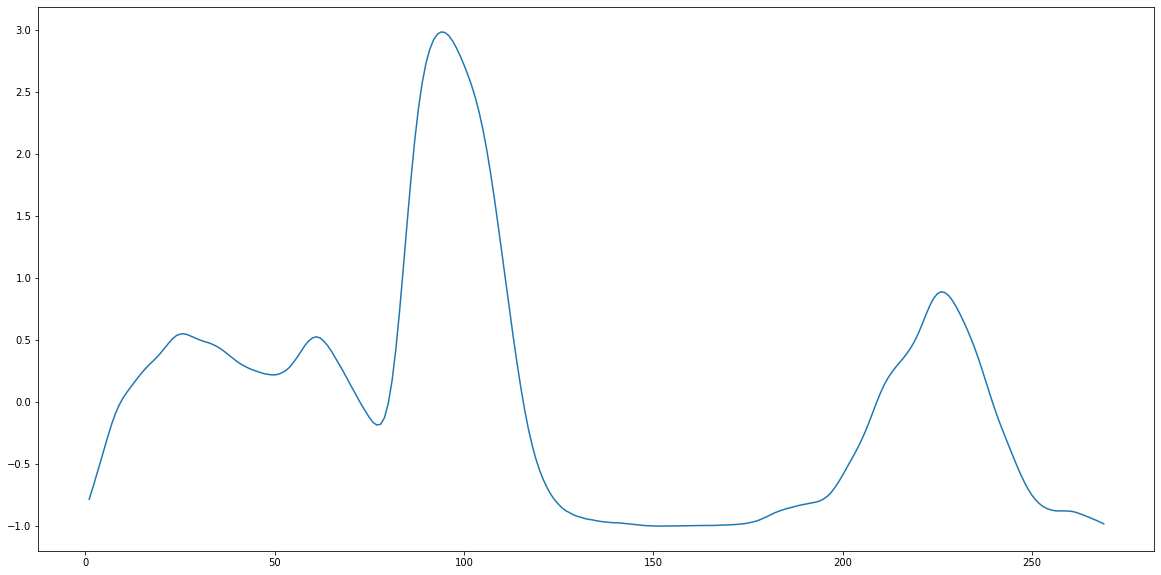

In [ ]:
words.iloc[1, 1:-1].plot()

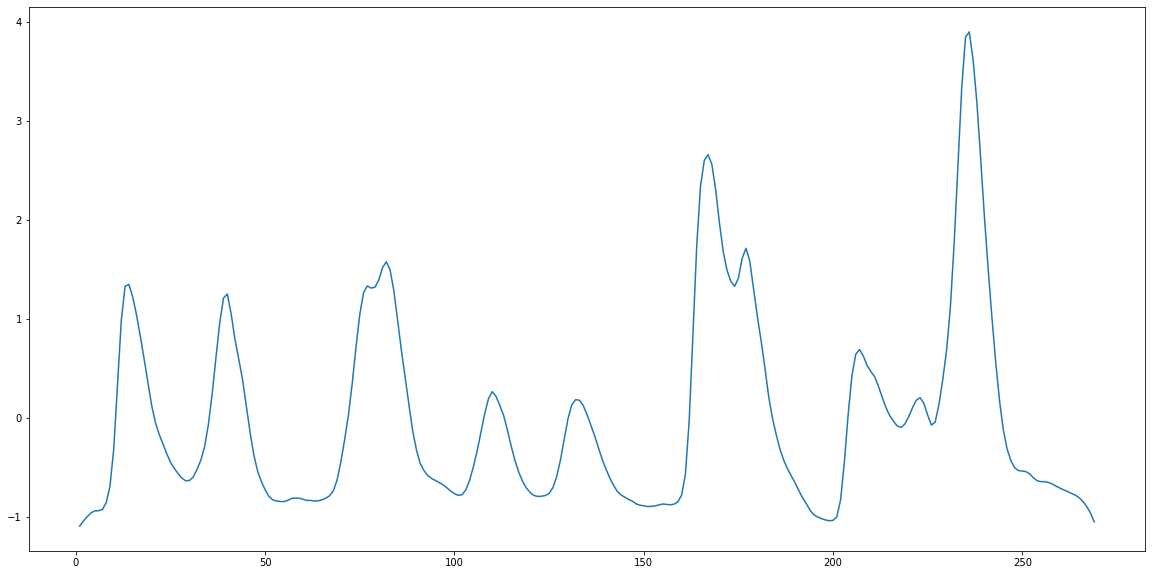

In [ ]:
words.iloc[3, 1:-1].plot()

서로 다른 이 단어들을 구분하는 몇 가지 특징
- 최고점에 대한 시간의 위치(x축)
- 두 번째 최고점에 대한 시간의 위치
- 최고점의 개수
- 값들의 전체 범위
- 곡선의 볼록성 등

그러나.. 각 고점의 위치를 정하는 특징을 생성하기는 쉽지 않다.


그래서 모든 범주별 데이터나 개별 데이터의 1D 히스토그램을 활용해볼 수 있다.

(고점을 식별하거나, 시계열 전체 모양을 매핑하는 다른 대체 값을 찾는 데에 계산 측면에서 덜 부담스러움)

Text(0.5, 0.98, 'Sample word projections and histograms of the projections')

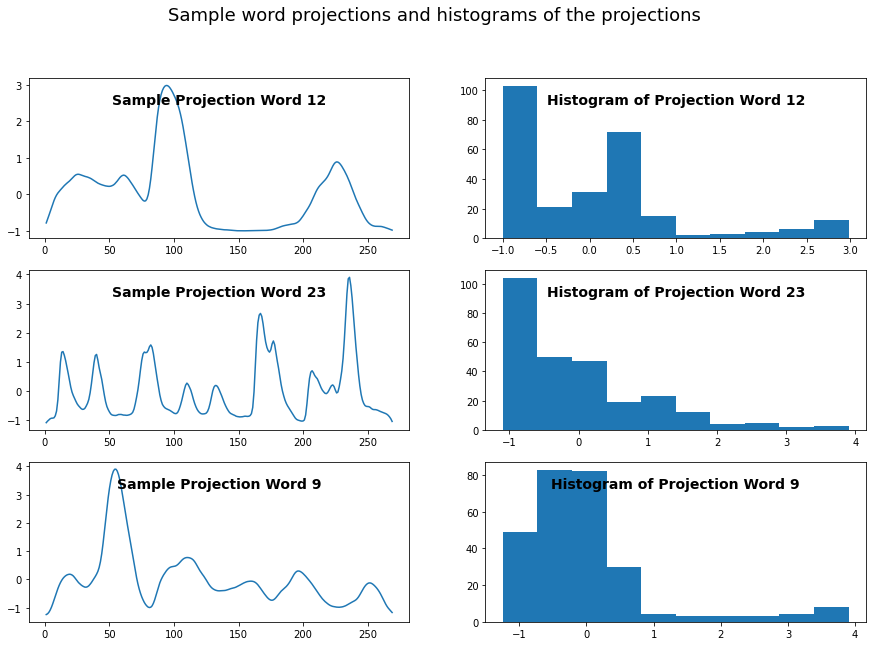

In [ ]:
# 동일한 범주별 데이터 1D 히스토그램으로 표현하기
plt.subplot(3, 2, 1)
plt.plot(words.iloc[1, 1:-1])
plt.title("Sample Projection Word " + str(words.word[1]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 2)
plt.hist(words.iloc[1, 1:-1], 10)
plt.title("Histogram of Projection Word " + str(words.word[1]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 3)
plt.plot(words.iloc[3, 1:-1])
plt.title("Sample Projection Word " + str(words.word[3]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 4)
plt.hist(words.iloc[3, 1:-1], 10)
plt.title("Histogram of Projection Word " + str(words.word[3]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 5)
plt.plot(words.iloc[5, 1:-1])
plt.title("Sample Projection Word " + str(words.word[11]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 6)
plt.hist(words.iloc[5, 1:-1], 10)
plt.title("Histogram of Projection Word " + str(words.word[11]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.suptitle("Sample word projections and histograms of the projections", fontsize = 18)

이는 유용한 특징을 발견하기 위해 각 범주를 측정하는 또 다른 방법이다.

특히 범주별 데이터의 히스토그램은 국소적 고점의 개수, 뒤틀림, 첨도와 같이 시계열 곡선을 잘 표현할 수 있는 대체 속성을 나타낸다. 

사람의 눈으로는 분명해보이는 속성들은 코드로 표현하기 어렵다.

In [ ]:
words[words.word == 12]

,word,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270
1,12,-0.78346,-0.68562,-0.58409,-0.47946,-0.37398,-0.27008,-0.17225,-0.087463,-0.019191,0.035301,0.080601,0.12121,0.16167,0.20223,0.239730,0.273860,0.305240,0.33417,0.364750,0.399670,0.436950,0.474700,0.509190,0.534400,0.54755,0.549650,0.542360,0.529090,0.515230,0.503070,0.491830,0.48213,0.47245,0.45929,0.44309,0.42404,0.40053,0.37585,0.35189,...,0.711070,0.647730,0.579890,0.506740,0.427670,0.341550,0.248490,0.152210,0.056228,-0.036684,-0.123520,-0.204720,-0.282990,-0.359170,-0.433970,-0.507940,-0.578640,-0.64302,-0.70017,-0.74901,-0.78785,-0.81818,-0.84200,-0.85809,-0.86830,-0.87519,-0.87721,-0.87661,-0.87728,-0.87899,-0.88318,-0.89189,-0.90290,-0.91427,-0.92668,-0.93966,-0.95244,-0.96623,-0.98050,-0.99178
55,12,-0.65904,-0.62525,-0.58935,-0.54896,-0.50556,-0.46049,-0.41860,-0.385650,-0.359560,-0.338580,-0.322480,-0.30840,-0.29826,-0.29244,-0.286430,-0.280400,-0.273060,-0.26323,-0.256180,-0.251520,-0.248130,-0.248420,-0.248460,-0.244590,-0.23437,-0.209560,-0.164040,-0.094924,0.001522,0.123680,0.267220,0.42740,0.59400,0.75686,0.90731,1.03640,1.14280,1.22850,1.29440,...,-0.596280,-0.535420,-0.466510,-0.396300,-0.331980,-0.278860,-0.240040,-0.216740,-0.208350,-0.212990,-0.227700,-0.248870,-0.272980,-0.297360,-0.320460,-0.341570,-0.360450,-0.37710,-0.39184,-0.40539,-0.41873,-0.43267,-0.44748,-0.46287,-0.47831,-0.49349,-0.50862,-0.52425,-0.54076,-0.55814,-0.57579,-0.59332,-0.61147,-0.63093,-0.65236,-0.67554,-0.69730,-0.71463,-0.72615,-0.73123
147,12,-0.71717,-0.68091,-0.63841,-0.58892,-0.53264,-0.47139,-0.40747,-0.344300,-0.286010,-0.234900,-0.191560,-0.15565,-0.12682,-0.10352,-0.084548,-0.069375,-0.057266,-0.04693,-0.037601,-0.030110,-0.024582,-0.021632,-0.022047,-0.026295,-0.03320,-0.041518,-0.051102,-0.061371,-0.071801,-0.082305,-0.093497,-0.10396,-0.11262,-0.11996,-0.12681,-0.13336,-0.14024,-0.14992,-0.16102,...,-0.784830,-0.783840,-0.782730,-0.781010,-0.778050,-0.773490,-0.767330,-0.759800,-0.751020,-0.740750,-0.728290,-0.712870,-0.694050,-0.672090,-0.648140,-0.623910,-0.601340,-0.58208,-0.56733,-0.55774,-0.55349,-0.55441,-0.56002,-0.56960,-0.58217,-0.59674,-0.61236,-0.62830,-0.64411,-0.65961,-0.67476,-0.68960,-0.70420,-0.71863,-0.73292,-0.74692,-0.76027,-0.77238,-0.78246,-0.78987
222,12,-0.53903,-0.53955,-0.55822,-0.57715,-0.58502,-0.58534,-0.58722,-0.593270,-0.599030,-0.600760,-0.599830,-0.59923,-0.59935,-0.59871,-0.597190,-0.596470,-0.597580,-0.59959,-0.601060,-0.601560,-0.601680,-0.601870,-0.602140,-0.602580,-0.60331,-0.604060,-0.603930,-0.602670,-0.600810,-0.599260,-0.598290,-0.59718,-0.59534,-0.59307,-0.59137,-0.59080,-0.59081,-0.59048,-0.58941,...,-0.538140,-0.481500,-0.398790,-0.295750,-0.184640,-0.080971,0.003016,0.059882,0.088580,0.093776,0.083362,0.065894,0.046004,0.023565,-0.004355,-0.039651,-0.080948,-0.12445,-0.16618,-0.20356,-0.23554,-0.26209,-0.28396,-0.30240,-0.31882,-0.33409,-0.34848,-0.36135,-0.37216,-0.38132,-0.38973,-0.40127,-0.41837,-0.44366,-0.47650,-0.51240,-0.54696,-0.57395,-0.59174,-0.60066
294,12,-0.77367,-0.71285,-0.64288,-0.57090,-0.50449,-0.44685,-0.39856,-0.359380,-0.326620,-0.298220,-0.273660,-0.25145,-0.23117,-0.21394,-0.200010,-0.190320,-0.185980,-0.18589,-0.188720,-0.193360,-0.197890,-0.201860,-0.206020,-0.210410,-0.21583,-0.222780,-0.230170,-0.237380,-0.243710,-0.247940,-0.250790,-0.25284,-0.25385,-0.25559,-0.25779,-0.25931,-0.26309,-0.26884,-0.27536,...,0.406400,0.362000,0.314850,0.263510,0.207300,0.145950,0.080034,0.012174,-0.054457,-0.116750,-0.171800,-0.218160,-0.255710,-0.285430,-0.308940,-0.326750,-0.339060,-0.34738,-0.35258,-0.35647,-0.36159,-0.36660,-0.37039,-0.37437,-0.37829,-0.38335,-0.39088,-0.39758,-0.40341,-0.41378,-0.43335,-0.46619,-0.51009,-0.55327,-0.58751,-0.61489,-0.64465,-0.68912,-0.75058,-0.81450
2

Text(0, 0.5, 'Value')

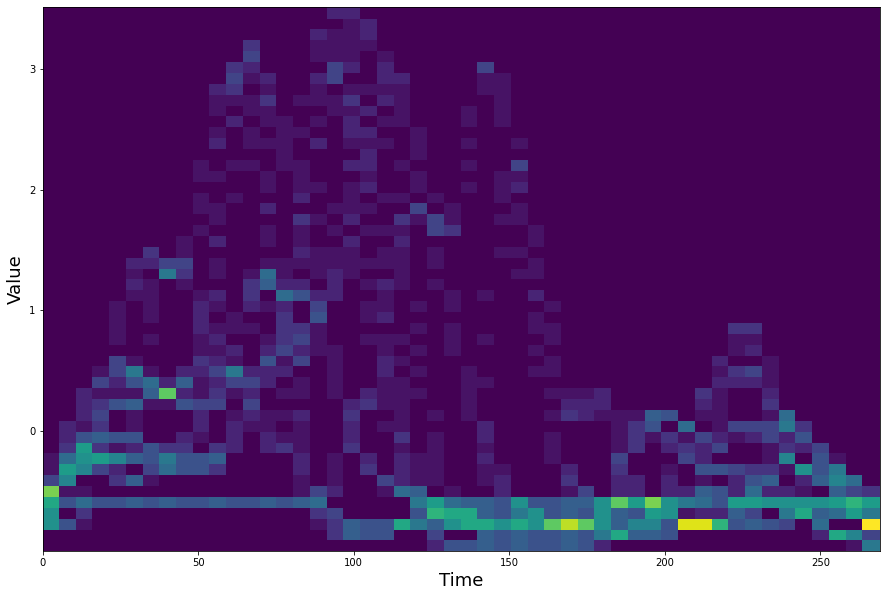

In [ ]:
## 단어의 2D 히스토그램을 구성할 수도 있음 (word = 12)
x = np.array([])
y = np.array([])

w = 12  # word = 12
selected_words = words[words.word == w]
selected_words.shape

for idx, row in selected_words.iterrows():
    y = np.hstack([y, row[1:271]])
    x = np.hstack([x, np.array(range(270))])
    
fig, ax = plt.subplots()
hist = ax.hist2d(x, y, bins = 50)
plt.xlabel("Time", fontsize = 18)
plt.ylabel("Value", fontsize = 18)

단어(word=12)를 1D로 투영한 것에 대한 2D 히스토그램.

x축은 투영된 각 시계열의 샘플/단어에 대한 270개의 시간 단계,

y축은 각 시간 단계에서의 측정값.

데이터셋 중 word=12에 포함된 모든 단어의 2D 히스토그램이다.

앞서 보았던 곡선 그래프는 시계열을 지배하는 두 고점을 찾는 데 초점을 두지만,

이 2D 히스토그램은 범주별 데이터 대부분이 **두 고점 사이에 평평함을 공통으로 가진다는 사실을, 120~200번째 시간 단계의 강도를 통해** 보여준다.


또한 이 범주(word=12)에 속한 최고점을 특정할 수 있다.

50~150시간 단계 사이에서 위치가 미묘-하게 다른 것이 보임에 따라서,

**최댓값이 50~150시간 단계 사이에 도달했는가?**와 같은 특징을 만들어야 할 수도 있다.

Text(0, 0.5, 'Value')

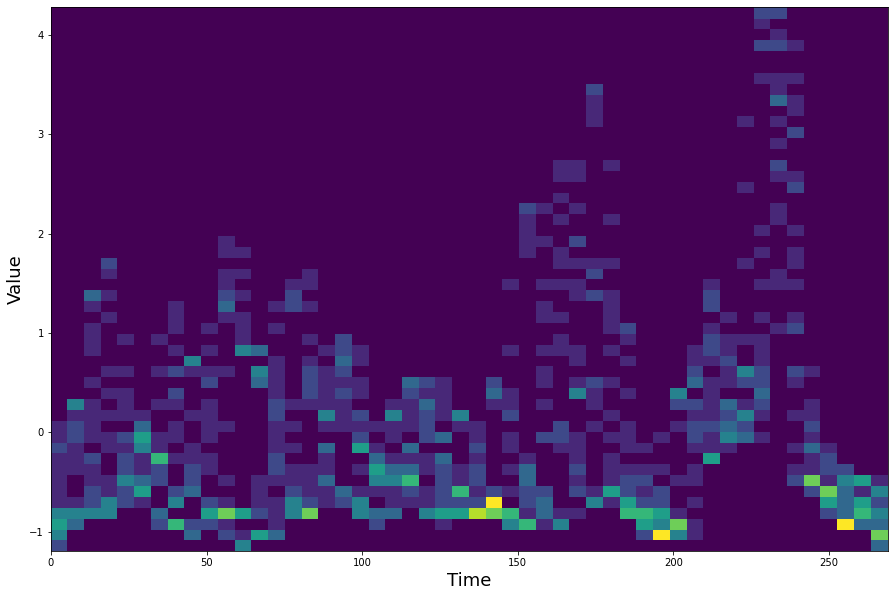

In [ ]:
## 단어의 2D 히스토그램을 구성할 수도 있음 (word = 23)
x = np.array([])
y = np.array([])

w = 23  # word = 23
selected_words = words[words.word == w]
selected_words.shape

for idx, row in selected_words.iterrows():
    y = np.hstack([y, row[1:271]])
    x = np.hstack([x, np.array(range(270))])
    
fig, ax = plt.subplots()
hist = ax.hist2d(x, y, bins = 50)
plt.xlabel("Time", fontsize = 18)
plt.ylabel("Value", fontsize = 18)

단어(work=23)

앞의 곡선 그래프에서는 정량화되기 어려웠던 특징인 작은 혹들이 많이 있다.

word=12와 비교하면 최고점이 겹치지 않는 시간 단계의 범위에 있다.

Time 150 이후에 등장.

-----
생성하기 위한 특징들
- 단어 투영의 모양에서 파생된 특징
- 단어 투영 히스토그램의 모양에서 파생된 특징(1D 요약을 또 다른 1D 요약으로 투영)
  - 이는 2D 히스토그램에서 볼 수 있는 큰 '얼룩짐'에 대한 대응으로, 고점은 있지만 그 위치가 안정적이지 않음을 표현한다.

히스토그램을 사용해 생성한 각 단어의 투영에 대한 2차적인 특징은, 

단순히 단어 그 자체를 투영하는 것보다 더 안정적이고, 특징을 잘 나타낼 수도 있다.

히스토그램은 value들의 **위치를 특정짓지 않고**, 그 value의 **종류를 나타낸다.**

이는 고점이 안정적인 시간의 위치에 분포되지 않은, 투영된 시계열을 다루는 이번 예제에서 중요한 역할을 한다.

In [ ]:
word_vals = words.iloc[:, 1:271]
word_vals.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270
0,-0.89094,-0.86099,-0.82438,-0.78214,-0.73573,-0.68691,-0.63754,-0.589370,-0.543420,-0.500440,-0.460820,-0.42469,-0.39240,-0.36389,-0.33906,-0.31795,-0.300560,-0.286920,-0.277270,-0.271050,-0.267770,-0.266780,-0.267420,-0.269270,-0.272020,-0.275290,-0.278980,-0.283200,-0.288140,-0.294310,-0.301850,-0.31086,-0.321350,-0.333260,-0.346500,-0.361030,-0.37659,-0.39297,-0.40995,-0.42731,...,0.052471,-0.01492,-0.082568,-0.14848,-0.21193,-0.27229,-0.32905,-0.38303,-0.432220,-0.476280,-0.51587,-0.55188,-0.58534,-0.61763,-0.64653,-0.67227,-0.69521,-0.71576,-0.73517,-0.75286,-0.76798,-0.78120,-0.79326,-0.80474,-0.81719,-0.82831,-0.83768,-0.84538,-0.85165,-0.85731,-0.86309,-0.86791,-0.87271,-0.87846,-0.88592,-0.89619,-0.90783,-0.91942,-0.93018,-0.93939
1,-0.78346,-0.68562,-0.58409,-0.47946,-0.37398,-0.27008,-0.17225,-0.087463,-0.019191,0.035301,0.080601,0.12121,0.16167,0.20223,0.23973,0.27386,0.305240,0.334170,0.364750,0.399670,0.436950,0.474700,0.509190,0.534400,0.547550,0.549650,0.542360,0.529090,0.515230,0.503070,0.491830,0.48213,0.472450,0.459290,0.443090,0.424040,0.40053,0.37585,0.35189,0.32803,...,0.711070,0.64773,0.579890,0.50674,0.42767,0.34155,0.24849,0.15221,0.056228,-0.036684,-0.12352,-0.20472,-0.28299,-0.35917,-0.43397,-0.50794,-0.57864,-0.64302,-0.70017,-0.74901,-0.78785,-0.81818,-0.84200,-0.85809,-0.86830,-0.87519,-0.87721,-0.87661,-0.87728,-0.87899,-0.88318,-0.89189,-0.90290,-0.91427,-0.92668,-0.93966,-0.95244,-0.96623,-0.98050,-0.99178
2,-1.32560,-1.28430,-1.21970,-1.15670,-1.09980,-1.04960,-1.01550,-0.996720,-0.985040,-0.971990,-0.964030,-0.96355,-0.96236,-0.95077,-0.91733,-0.87105,-0.817930,-0.760640,-0.701060,-0.644150,-0.594710,-0.529310,-0.409210,-0.205990,0.066333,0.344810,0.565100,0.703590,0.785270,0.840450,0.870940,0.85764,0.775790,0.634510,0.480380,0.351620,0.24100,0.11593,-0.02214,-0.15289,...,-0.443510,-0.43741,-0.444480,-0.45708,-0.46691,-0.47419,-0.47495,-0.46916,-0.456730,-0.439730,-0.42135,-0.40614,-0.40352,-0.41293,-0.42965,-0.44611,-0.45623,-0.46585,-0.48431,-0.52010,-0.56853,-0.61788,-0.65943,-0.68651,-0.70204,-0.71318,-0.72646,-0.74568,-0.77144,-0.80390,-0.83499,-0.86204,-0.88559,-0.90454,-0.93353,-0.99135,-1.06910,-1.13680,-1.19800,-1.27000
3,-1.09370,-1.04200,-0.99840,-0.95997,-0.93997,-0.93764,-0.92649,-0.857090,-0.693320,-0.312890,0.339420,0.98909,1.33000,1.34950,1.22290,1.04450,0.829670,0.602100,0.365250,0.128330,-0.046387,-0.165640,-0.265030,-0.362500,-0.449520,-0.510830,-0.562550,-0.608530,-0.635880,-0.632320,-0.597000,-0.52032,-0.427310,-0.291990,-0.066752,0.241280,0.61050,0.96181,1.21160,1.25220,...,1.115600,1.76630,2.558000,3.33430,3.84940,3.90180,3.62190,3.18950,2.623000,2.031000,1.49790,1.00600,0.55445,0.16993,-0.12355,-0.31586,-0.43344,-0.50570,-0.53268,-0.53688,-0.54374,-0.56792,-0.60857,-0.63638,-0.64471,-0.64440,-0.65382,-0.66957,-0.69135,-0.71082,-0.72810,-0.74512,-0.76376,-0.78068,-0.80593,-0.84350,-0.89531,-0.96052,-1.05090,-1.12830
4,-0.90138,-0.85228,-0.80196,-0.74932,-0.69298,-0.63316,-0.57038,-0.506920,-0.446040,-0.390180,-0.339310,-0.29231,-0.24833,-0.20635,-0.16585,-0.12719,-0.091931,-0.059946,-0.030921,-0.004628,0.018364,0.038239,0.054732,0.067206,0.075442,0.080507,0.083344,0.083628,0.081179,0.075684,0.066456,0.05167,0.032078,0.008739,-0.017323,-0.046021,-0.07580,-0.10581,-0.13622,-0.16717,...,-0.394410,-0.37672,-0.357160,-0.33905,-0.32255,-0.30807,-0.29818,-0.29607,-0.300260,-0.310800,-0.32809,-0.35262,-0.38035,-0.41034,-0.44236,-0.47573,-0.50864,-0.54145,-0.57506,-0.60889,-0.64237,-0.67593,-0.71042,-0.74502,-0.77959,-0.81402,-0.84805,-0.87959,-0.90785,-0.93276,-0.95452,-0.97322,-0.98984,-1.00520,-1.01880,-1.02960,-1.03700,-1.04110,-1.04180,-1.04030


In [ ]:
from cesium import featurize as ft

In [ ]:
dir(ft)

['Imputer',
 'Iterable',
 'TimeSeries',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'assemble_featureset',
 'copy',
 'cull',
 'dask',
 'delayed',
 'featurize_single_ts',
 'featurize_time_series',
 'featurize_ts_files',
 'generate_dask_graph',
 'impute_featureset',
 'load_featureset',
 'np',
 'pack_exception',
 'pd',
 'reraise',
 'save_featureset',
 'time_series']

In [ ]:
# 시간 단계 270개를 가진 시계열의 특징 생성

word_vals = words.iloc[:, 1:271]
times  = []
word_values = []
for idx, row in word_vals.iterrows():
    word_values.append(row.values)
    times.append(np.array([i for i in range(row.values.shape[0])]))

features_to_use = ['amplitude',
                   'percent_beyond_1_std',
                   'percent_close_to_median']
featurized_words = ft.featurize_time_series(times = times,
                                            values = word_values,
                                            errors = None,
                                            features_to_use = features_to_use,
                                            scheduler = None)

In [ ]:
featurized_words

feature,amplitude,percent_beyond_1_std,percent_close_to_median
channel,0,0,0
0,1.674555,0.188889,0.451852
1,1.990520,0.118519,0.259259
2,2.903650,0.114815,0.637037
3,2.515050,0.211111,0.562963
4,1.966150,0.181481,0.533333
...,...,...,...
450,2.134920,0.122222,0.629630
451,2.218890,0.140741,0.681481
452,2.487500,0.155556,0.414815


In [ ]:
# 다음으로 히스토그램을 생성하고, 이를 또 다른 시계열로 취급하여 특징 생성

## 히스토그램에서 파생된 일부 특징 생성
times  = []
hist_values = []
for idx, row in word_vals.iterrows():
    hist_values.append(np.histogram(row.values, 
                                    bins=10, 
                                    range=(-2.5, 5.0))[0] + .0001)  # 0은 하위 작업에서 문제 발생하기 때문
    times.append(np.array([i for i in range(9)]))

features_to_use = ['amplitude',
                   'percent_close_to_median',
                   'skew']
featurized_hists = ft.featurize_time_series(times = times,
                                            values = hist_values,
                                            errors = None,
                                            features_to_use = features_to_use,
                                            scheduler = None)

In [ ]:
len(hist_values)

455

In [ ]:
featurized_hists

feature,amplitude,percent_close_to_median,skew
channel,0,0,0
0,88.0,0.444444,2.262655
1,61.0,0.666667,1.285343
2,70.0,0.666667,1.683031
3,67.0,0.555556,1.724109
4,75.0,0.777778,1.902513
...,...,...,...
450,74.0,0.777778,1.661334
451,80.0,0.777778,1.971053
452,58.5,0.666667,1.263944


주의해야 할 점:
- np.histogram()에 전달된 인수는 모든 히스토그램이 같은 개수의 구간, 같은 범위의 값들로 구성되도록 한다
- 이러한 '시간의 축'으로써의 일관성 없이는 히스토그램 간 비교가 불가능하여 생성된 특징이 무의미하다


In [ ]:
# 서로 다른 방식으로 얻은 특징들 결합
features = pd.concat([featurized_words.reset_index(drop=True),
                      featurized_hists],
                     axis=1)

In [119]:
features

feature,amplitude,percent_beyond_1_std,percent_close_to_median,amplitude,percent_close_to_median,skew
channel,0,0,0,0,0,0
0,1.674555,0.188889,0.451852,88.0,0.444444,2.262655
1,1.990520,0.118519,0.259259,61.0,0.666667,1.285343
2,2.903650,0.114815,0.637037,70.0,0.666667,1.683031
3,2.515050,0.211111,0.562963,67.0,0.555556,1.724109
4,1.966150,0.181481,0.533333,75.0,0.777778,1.902513
...,...,...,...,...,...,...
450,2.134920,0.122222,0.629630,74.0,0.777778,1.661334
451,2.218890,0.140741,0.681481,80.0,0.777778,1.971053
452,2.487500,0.155556,0.414815,58.5,0.666667,1.263944


### **2.2 시간을 인식하는 거리 측정법**
클러스터링(Clustering) 분석 시, 거리 지표를 선택해야 한다.

비시계열 데이터에 대한 표준 클러스터링 분석과 마찬가지로, 

시계열 특징에도 다양한 표준 거리 지표를 적용할 수 있다.

거리 지표의 선택 과정에 익숙하지 않다면 참고:
- https://stats.stackexchange.com/questions/3713/choosing-a-clustering-method

-----
이번 절에서는 시계열 간의 유사성 측정 문제를 다루기 위한 거리 지표를 정의한다.

이러한 목적의 거리 지표 중 가장 잘 알려진 것은 **동적시간왜곡(DTW, Dynamic Time Warping)**이다.

- DTW에 대하여 더 알아보고 싶다면 참고
  - https://ichi.pro/ko/dongjeog-sigan-waegog-e-daehan-seolmyeong-60106327800728

DTW는 단어 투영과 같이, **전체적인 모양**이 가장 중요한 특징인 시계열의 클러스터링에 적합하다.

이 기법의 이름은 시간축을 따라 시계열을 정렬하고,

모양을 비교하는 시간적 **'왜곡'**에 의존하는 방법론으로부터 영감을 받았다고 한다.



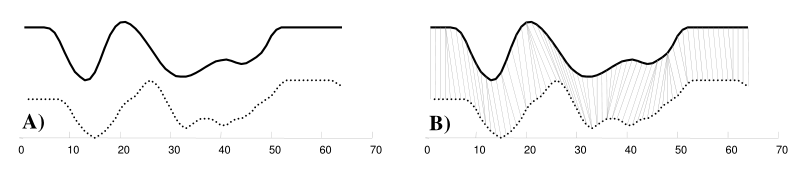

(출처: https://www.codetd.com/ko/article/10565218)

그림 B)에 표시된 두 곡선(두 시계열) 사이의 점선 중 최상의 정렬을 찾아서, 

두 곡선의 모양을 비교하기 위해 시간축(x)이 왜곡(확장 or 축소)된다.

- 시계열의 각 점은 반대편 시계열의 점에 매핑되지만, 반드시 일대일 관계로 매핑될 필요하는 없음
  - 시계열의 길이가 같거나 시간 범위가 같을 필요는 없다. 모양이 중요하다.
  - 적합과정에서 각 시계열에 대한 시간이 항상 뒤로 이동하는 것은 아니며, 이동속도도 동일하지 않다(여기서 말하는 시간 이동은 x축 방향으로 곡선을 따라 진행되는 것).

위와 같은 성질 때문에, 나노초 단위로 측정된 시계열과 수천 년 단위로 측정된 시계열도 비교할 수 있다.

이 알고리즘의 목적 자체가 지나간 시간의 **'양'**보다는 알고리즘의 시각적 **'모양'**을 비교하는 것에 가깝다.

즉 **'시간'**이란 고유한 시간보다는, x축을 따라 균등한 간격으로 정렬된 점들이라는 일반화된 의미가 있다.

-----
DTW의 규칙
- 한 시계열의 모든 시간은 최소한 다른 시계열의 하나의 시간에 대응해야 한다.
- 각 시계열의 처음과 끝은 서로의 처음과 끝에 대응해야 한다.
- 시간 간의 매핑은 과거가 아니라, 미래로 이동하는 관계만 표현해야 한다. 한 시계열의 시간축상에서 이미 지난 시간을 다른 시계열의 시간에 대응할 수는 없다. 가령, 그림 B)의 시간 단위 14 즈음에 위치하는 왜곡된 지점에서 알 수 있듯이, 적합 과정에서 시계열의 두 연속적인 시간 단계는 x축의 동일한 위치로 압축되어 왜곡된다.

이 규칙을 따르도록 시간 정렬을 조정하는 여러 방법이 있지만, 

중요한 것은 적합으로부터 선택된 두 곡선을 매핑시킨 결과는 곡선의 거리를 최소화한 것이어야 한다는 점이다.

이 거리나 비용함수(cost function)는 대응된 점 간의 차이에 대한 절댓값의 합으로 측정되는 경우가 일반적이다.

차이에 대한 절댓값이란, 두 시계열이 서로 다른 정도를 말한다.

#### **예제 code**